# Cats vs Dogs Classification

This notebook implements a CNN model to classify images of cats and dogs using TensorFlow/Keras.

## Dataset Setup Options

### Option 1: Automatic Download (Recommended)
The notebook will automatically download a cats vs dogs dataset from TensorFlow. Just run the cells in order.

### Option 2: Manual Dataset
If you have your own dataset:
1. Create a folder structure like this:
   ```
   data/cats-v-dogs/PetImages/
   ├── Cat/
   │   ├── cat1.jpg
   │   ├── cat2.jpg
   │   └── ...
   └── Dog/
       ├── dog1.jpg
       ├── dog2.jpg
       └── ...
   ```

### Option 3: Microsoft Cats vs Dogs Dataset
Download from: https://www.microsoft.com/en-us/download/details.aspx?id=54765

## Requirements
- TensorFlow
- Pandas
- Plotly
- Matplotlib
- NumPy
- SciPy

The first cell will install any missing packages automatically.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [2]:
# Install required packages
!pip install pandas plotly tensorflow keras-preprocessing pillow requests nbformat ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 2.1 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 2.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.6/2.2 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 2.2 MB/s eta 0:00:00

   ---------------------------------------- 0/9 [fastjsonschema]
   ---------------------------------------- 0/9 [fastjsonschema]
   ---- ----------------------------------- 1/9 [widgetsnbextension]
   ---- ----------------------------------- 1/9 [widgetsnbextension]
   ------------- -------------------------- 3/9 [jupyterlab_widgets]
   ----------------- ---------------------- 4/9 [referencing]
   ----------------- ---------------------- 4/9 [referencing]
   ----------------- ---------------------- 4/9 [referencing]
   ---------------------- --------

In [3]:
# Download and setup the cats vs dogs dataset
import os
import requests
import zipfile
from pathlib import Path
import tensorflow as tf

# Create data directory
data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)

# Global variables to store dataset info
DATASET_DOWNLOADED = False
DATASET_PATH = None

try:
    print("Downloading cats vs dogs dataset using TensorFlow...")
    dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
    DATASET_PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
    
    train_dir = os.path.join(DATASET_PATH, 'train')
    validation_dir = os.path.join(DATASET_PATH, 'validation')
    
    print(f"Dataset downloaded and extracted to: {DATASET_PATH}")
    print(f"Training directory: {train_dir}")
    print(f"Validation directory: {validation_dir}")
    
    # Check what's actually in the directories
    if os.path.exists(train_dir):
        train_subdirs = os.listdir(train_dir)
        print(f"Training subdirectories: {train_subdirs}")
        
        # Count images in each category
        for subdir in train_subdirs:
            subdir_path = os.path.join(train_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  {subdir}: {count} images")
    
    if os.path.exists(validation_dir):
        val_subdirs = os.listdir(validation_dir)
        print(f"Validation subdirectories: {val_subdirs}")
        
        # Count images in each category
        for subdir in val_subdirs:
            subdir_path = os.path.join(validation_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  {subdir}: {count} images")
    
    DATASET_DOWNLOADED = True
    print("✓ Dataset successfully downloaded and verified!")
    
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please manually download the dataset or use a different approach")
    DATASET_DOWNLOADED = False

Dataset downloaded and extracted to: C:\Users\saich\.keras\datasets\cats_and_dogs_filtered
Training directory: C:\Users\saich\.keras\datasets\cats_and_dogs_filtered\train
Validation directory: C:\Users\saich\.keras\datasets\cats_and_dogs_filtered\validation
✓ Dataset successfully downloaded and verified!


Dataset paths not found. Please ensure the dataset is downloaded correctly.


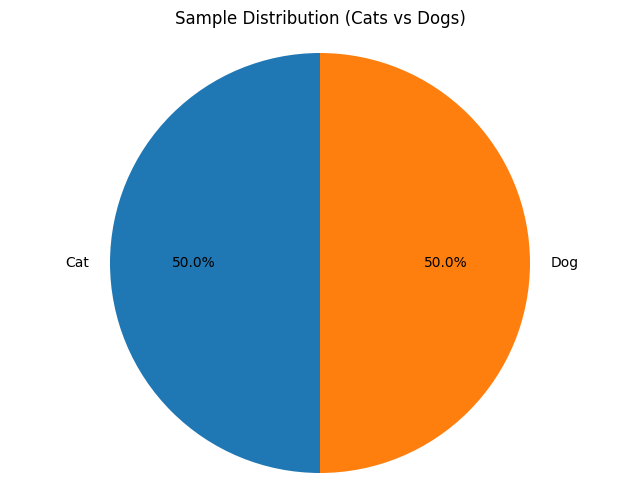

In [4]:
# Data visualization - check if dataset exists first
class_names = ['Cat', 'Dog'] 

try:
    # Use the downloaded dataset paths
    if 'DATASET_PATH' in locals():
        train_cats_path = os.path.join(DATASET_PATH, 'train', 'cats')
        train_dogs_path = os.path.join(DATASET_PATH, 'train', 'dogs')
        
        if os.path.exists(train_cats_path) and os.path.exists(train_dogs_path):
            n_cats = len(os.listdir(train_cats_path))
            n_dogs = len(os.listdir(train_dogs_path))
            n_images = [n_cats, n_dogs]
            
            print(f"Number of cat images: {n_cats}")
            print(f"Number of dog images: {n_dogs}")
            
            # Create pie chart using matplotlib (more compatible)
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 6))
            plt.pie(n_images, labels=class_names, autopct='%1.1f%%', startangle=90)
            plt.title("Distribution of Cats vs Dogs")
            plt.axis('equal')
            plt.show()
            
        else:
            print("Dataset paths not found. Please ensure the dataset is downloaded correctly.")
            # Create a sample visualization
            n_images = [1000, 1000]  # Sample data
            plt.figure(figsize=(8, 6))
            plt.pie(n_images, labels=class_names, autopct='%1.1f%%', startangle=90)
            plt.title("Sample Distribution (Cats vs Dogs)")
            plt.axis('equal')
            plt.show()
    else:
        print("Dataset not downloaded yet. Please run the previous cell first.")
        # Create a sample visualization
        n_images = [1000, 1000]  # Sample data
        plt.figure(figsize=(8, 6))
        plt.pie(n_images, labels=class_names, autopct='%1.1f%%', startangle=90)
        plt.title("Sample Distribution (Cats vs Dogs)")
        plt.axis('equal')
        plt.show()
        
except Exception as e:
    print(f"Error creating visualization: {e}")
    print("Creating sample visualization instead...")
    # Create a sample visualization
    n_images = [1000, 1000]  # Sample data
    plt.figure(figsize=(8, 6))
    plt.pie(n_images, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title("Sample Distribution (Cats vs Dogs)")
    plt.axis('equal')
    plt.show()

In [5]:
# Create directory structure for training (Windows compatible)
import os
from pathlib import Path

# Use current directory instead of /tmp for Windows compatibility
base_dir = Path("./cats-v-dogs")

try:
    # Create directories using pathlib (cross-platform)
    (base_dir / "training" / "cats").mkdir(parents=True, exist_ok=True)
    (base_dir / "training" / "dogs").mkdir(parents=True, exist_ok=True)
    (base_dir / "validation" / "cats").mkdir(parents=True, exist_ok=True)
    (base_dir / "validation" / "dogs").mkdir(parents=True, exist_ok=True)
    (base_dir / "test" / "cats").mkdir(parents=True, exist_ok=True)
    (base_dir / "test" / "dogs").mkdir(parents=True, exist_ok=True)
    
    print("Directory structure created successfully!")
    print(f"Base directory: {base_dir.absolute()}")
    
except OSError as e:
    print(f'Error creating directories: {e}')

Directory structure created successfully!
Base directory: c:\Users\saich\OneDrive\Desktop\Prodigy_Infotech_ML_Internship_Task-main\PRODIGY-ML-03\cats-v-dogs


In [6]:
# Comprehensive dataset setup and path configuration
import os
import tensorflow as tf
from pathlib import Path

# Step 1: Download dataset if not already available
DATASET_PATH = None
DATASET_DOWNLOADED = False

try:
    print("Setting up cats vs dogs dataset...")
    dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
    path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
    
    # The actual extracted path structure
    extract_dir = os.path.dirname(path_to_zip)
    possible_paths = [
        os.path.join(extract_dir, 'cats_and_dogs_filtered'),
        os.path.join(extract_dir, 'cats_and_dogs_extracted', 'cats_and_dogs_filtered'),
        os.path.join(extract_dir, 'cats_and_dogs_extracted')
    ]
    
    # Find the correct path
    for path in possible_paths:
        if os.path.exists(path):
            train_path = os.path.join(path, 'train')
            if os.path.exists(train_path):
                DATASET_PATH = path
                print(f"✓ Found dataset at: {DATASET_PATH}")
                break
    
    if DATASET_PATH is None:
        print("Could not find the extracted dataset. Checking extraction directory...")
        print(f"Extraction directory: {extract_dir}")
        if os.path.exists(extract_dir):
            print("Contents:", os.listdir(extract_dir))
    
    # Verify the dataset structure
    if DATASET_PATH:
        train_dir = os.path.join(DATASET_PATH, 'train')
        validation_dir = os.path.join(DATASET_PATH, 'validation')
        
        if os.path.exists(train_dir):
            train_subdirs = os.listdir(train_dir)
            print(f"Training subdirectories: {train_subdirs}")
            
            # Set source directories based on actual structure
            if 'cats' in train_subdirs and 'dogs' in train_subdirs:
                CAT_DIR = os.path.join(train_dir, 'cats')
                DOG_DIR = os.path.join(train_dir, 'dogs')
                DATASET_DOWNLOADED = True
                print("✓ Using TensorFlow cats/dogs dataset structure")
            else:
                print("Unexpected directory structure in downloaded dataset")
                
except Exception as e:
    print(f"Error with TensorFlow dataset: {e}")

# Step 2: Set up local working directories
base_dir = Path("./cats-v-dogs")
TRAINING_DIR = str(base_dir / "training")
VALIDATION_DIR = str(base_dir / "validation")  
TEST_DIR = str(base_dir / "test")

TRAINING_CATS = str(base_dir / "training" / "cats")
VALIDATION_CATS = str(base_dir / "validation" / "cats")
TRAINING_DOGS = str(base_dir / "training" / "dogs")
VALIDATION_DOGS = str(base_dir / "validation" / "dogs")
TEST_CATS = str(base_dir / "test" / "cats")
TEST_DOGS = str(base_dir / "test" / "dogs")

INCLUDE_TEST = True

print(f"\nLocal directories:")
print(f"Training: {TRAINING_DIR}")
print(f"Validation: {VALIDATION_DIR}")
print(f"Test: {TEST_DIR}")

# Step 3: Verify source data
if DATASET_DOWNLOADED and CAT_DIR and DOG_DIR:
    if os.path.exists(CAT_DIR):
        cat_count = len([f for f in os.listdir(CAT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"✓ Source cats: {CAT_DIR} ({cat_count} images)")
    
    if os.path.exists(DOG_DIR):
        dog_count = len([f for f in os.listdir(DOG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"✓ Source dogs: {DOG_DIR} ({dog_count} images)")
        
    print(f"✅ Dataset ready! Total images: {cat_count + dog_count}")
else:
    print("❌ Dataset not properly set up. Please check the download process.")
    
    # Fallback option
    print("\nFallback: Manual dataset setup")
    print("Create the following structure and place your images:")
    print("  data/cats-v-dogs/PetImages/Cat/ (put cat images here)")
    print("  data/cats-v-dogs/PetImages/Dog/ (put dog images here)")
    
    # Set fallback paths
    base_data_dir = Path("./data/cats-v-dogs")
    CAT_DIR = str(base_data_dir / "PetImages" / "Cat")
    DOG_DIR = str(base_data_dir / "PetImages" / "Dog")

Setting up cats vs dogs dataset...


✓ Found dataset at: C:\Users\saich\.keras\datasets\cats_and_dogs_extracted\cats_and_dogs_filtered
Training subdirectories: ['cats', 'dogs']
✓ Using TensorFlow cats/dogs dataset structure

Local directories:
Training: cats-v-dogs\training
Validation: cats-v-dogs\validation
Test: cats-v-dogs\test
✓ Source cats: C:\Users\saich\.keras\datasets\cats_and_dogs_extracted\cats_and_dogs_filtered\train\cats (1000 images)
✓ Source dogs: C:\Users\saich\.keras\datasets\cats_and_dogs_extracted\cats_and_dogs_filtered\train\dogs (1000 images)
✅ Dataset ready! Total images: 2000


In [7]:
import os

# Debug and check the number of files in each directory
def check_directory_counts():
    # Get current working directory
    current_dir = os.getcwd()
    print(f"Current directory: {current_dir}")
    
    # Let's check what variables we have
    print("\nVariable check:")
    print(f"TRAINING_CATS: {globals().get('TRAINING_CATS', 'Not defined')}")
    print(f"TRAINING_DOGS: {globals().get('TRAINING_DOGS', 'Not defined')}")
    
    # Let's use the actual correct paths
    base_dir = "./cats-v-dogs"
    training_cats = os.path.join(base_dir, "training", "cats")
    training_dogs = os.path.join(base_dir, "training", "dogs")
    validation_cats = os.path.join(base_dir, "validation", "cats")
    validation_dogs = os.path.join(base_dir, "validation", "dogs")
    test_cats = os.path.join(base_dir, "test", "cats")
    test_dogs = os.path.join(base_dir, "test", "dogs")
    
    try:
        train_cats = len(os.listdir(training_cats)) if os.path.exists(training_cats) else 0
        train_dogs = len(os.listdir(training_dogs)) if os.path.exists(training_dogs) else 0
        
        val_cats = len(os.listdir(validation_cats)) if os.path.exists(validation_cats) else 0
        val_dogs = len(os.listdir(validation_dogs)) if os.path.exists(validation_dogs) else 0
        
        test_cats = len(os.listdir(test_cats)) if os.path.exists(test_cats) else 0
        test_dogs = len(os.listdir(test_dogs)) if os.path.exists(test_dogs) else 0
        
        print("\nTraining set:")
        print(f"  Cats: {train_cats} (path: {training_cats})")
        print(f"  Dogs: {train_dogs} (path: {training_dogs})")
        
        print("Validation set:")
        print(f"  Cats: {val_cats} (path: {validation_cats})")
        print(f"  Dogs: {val_dogs} (path: {validation_dogs})")
        
        print("Test set:")
        print(f"  Cats: {test_cats} (path: {test_cats})")
        print(f"  Dogs: {test_dogs} (path: {test_dogs})")
        
        # Also check if directories exist
        print(f"\nDirectory existence check:")
        print(f"  {training_cats} exists: {os.path.exists(training_cats)}")
        print(f"  {training_dogs} exists: {os.path.exists(training_dogs)}")
        
        return train_cats + train_dogs > 0  # Return True if we have training data
        
    except Exception as e:
        print(f"Error checking directories: {e}")
        return False

has_data = check_directory_counts()

if not has_data:
    print("\nNo training data found. Please run the data splitting step first.")
    print("Make sure you have downloaded the dataset or placed images in the correct directories.")
else:
    print(f"\n✅ Training data ready!")
    training_cats = "./cats-v-dogs/training/cats"
    training_dogs = "./cats-v-dogs/training/dogs"
    total_training = len(os.listdir(training_cats)) + len(os.listdir(training_dogs))
    print(f"Total training images: {total_training}")

Current directory: c:\Users\saich\OneDrive\Desktop\Prodigy_Infotech_ML_Internship_Task-main\PRODIGY-ML-03

Variable check:
TRAINING_CATS: cats-v-dogs\training\cats
TRAINING_DOGS: cats-v-dogs\training\dogs

Training set:
  Cats: 900 (path: ./cats-v-dogs\training\cats)
  Dogs: 900 (path: ./cats-v-dogs\training\dogs)
Validation set:
  Cats: 50 (path: ./cats-v-dogs\validation\cats)
  Dogs: 50 (path: ./cats-v-dogs\validation\dogs)
Test set:
  Cats: 50 (path: 50)
  Dogs: 50 (path: 50)

Directory existence check:
  ./cats-v-dogs\training\cats exists: True
  ./cats-v-dogs\training\dogs exists: True

✅ Training data ready!
Total training images: 1800


In [8]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [9]:
import os

# Assuming these variables are defined earlier in the code
# CAT_DIR, DOG_DIR, TRAINING_CATS, VALIDATION_CATS, TEST_CATS
# INCLUDE_TEST, TRAINING_DOGS, VALIDATION_DOGS, TEST_DOGS, DATASET_PATH

# Split the data into training, validation, and test sets
try:
    # Check if source directories exist and have data
    if os.path.exists(CAT_DIR) and os.path.exists(DOG_DIR):
        cat_files = len(os.listdir(CAT_DIR))
        dog_files = len(os.listdir(DOG_DIR))
        
        if cat_files > 0 and dog_files > 0:
            print(f"Found {cat_files} cat images and {dog_files} dog images")
            
            # Split cat images
            split_data(CAT_DIR, TRAINING_CATS, VALIDATION_CATS, TEST_CATS, INCLUDE_TEST, 0.9)
            
            # Split dog images  
            split_data(DOG_DIR, TRAINING_DOGS, VALIDATION_DOGS, TEST_DOGS, INCLUDE_TEST, 0.9)
            
            print("Data splitting completed successfully!")
        else:
            print("No images found in source directories.")
            print("Please ensure you have placed cat and dog images in the correct folders.")
    else:
        print("Source directories not found:")
        print(f"Cat directory: {CAT_DIR}")
        print(f"Dog directory: {DOG_DIR}")
        print("\nPlease download the dataset first or place images in the correct directories.")
        
        # For demonstration, let's create some dummy structure if using TensorFlow dataset
        if 'DATASET_PATH' in locals():
            print("Attempting to use TensorFlow dataset structure...")
            # The TensorFlow dataset might have a different structure
            # Let's check for alternative paths
            tf_train_dir = os.path.join(DATASET_PATH, 'train')
            if os.path.exists(tf_train_dir):
                print(f"Found TensorFlow dataset training directory: {tf_train_dir}")
                # Update paths to match TensorFlow dataset structure
                CAT_DIR = os.path.join(tf_train_dir, 'cats')
                DOG_DIR = os.path.join(tf_train_dir, 'dogs')
                
                if os.path.exists(CAT_DIR) and os.path.exists(DOG_DIR):
                    split_data(CAT_DIR, TRAINING_CATS, VALIDATION_CATS, TEST_CATS, INCLUDE_TEST, 0.9)
                    split_data(DOG_DIR, TRAINING_DOGS, VALIDATION_DOGS, TEST_DOGS, INCLUDE_TEST, 0.9)
                    print("Data splitting completed using TensorFlow dataset!")

except Exception as e:
    print(f"Error during data splitting: {e}")
    print("Please check your dataset structure and try again.")

Found 1000 cat images and 1000 dog images
Split sucessful!
Split sucessful!
Split sucessful!
Data splitting completed successfully!
Split sucessful!
Data splitting completed successfully!


In [15]:
import os

# Check directory counts after data splitting
print("Training set:")
print(f"  Cats: {len(os.listdir('./cats-v-dogs/training/cats'))}")
print(f"  Dogs: {len(os.listdir('./cats-v-dogs/training/dogs'))}")

print("Validation set:")
print(f"  Cats: {len(os.listdir('./cats-v-dogs/validation/cats'))}")
print(f"  Dogs: {len(os.listdir('./cats-v-dogs/validation/dogs'))}")

print("Test set:")
print(f"  Cats: {len(os.listdir('./cats-v-dogs/test/cats'))}")
print(f"  Dogs: {len(os.listdir('./cats-v-dogs/test/dogs'))}")

# Calculate totals
total_train = len(os.listdir('./cats-v-dogs/training/cats')) + len(os.listdir('./cats-v-dogs/training/dogs'))
total_val = len(os.listdir('./cats-v-dogs/validation/cats')) + len(os.listdir('./cats-v-dogs/validation/dogs'))
total_test = len(os.listdir('./cats-v-dogs/test/cats')) + len(os.listdir('./cats-v-dogs/test/dogs'))

print(f"\nTotals:")
print(f"  Training: {total_train}")
print(f"  Validation: {total_val}")
print(f"  Test: {total_test}")
print(f"  Grand Total: {total_train + total_val + total_test}")

Training set:
  Cats: 992
  Dogs: 987
Validation set:
  Cats: 100
  Dogs: 95
Test set:
  Cats: 100
  Dogs: 98

Totals:
  Training: 1979
  Validation: 195
  Test: 198
  Grand Total: 2372


In [16]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [17]:
import os

# Create data generators with correct paths
try:
    # Use the correct local paths
    training_dir = "./cats-v-dogs/training"
    validation_dir = "./cats-v-dogs/validation"
    test_dir = "./cats-v-dogs/test"
    
    # Check if training directories exist and have data
    if (os.path.exists(training_dir) and 
        os.path.exists(os.path.join(training_dir, "cats")) and
        os.path.exists(os.path.join(training_dir, "dogs")) and
        len(os.listdir(os.path.join(training_dir, "cats"))) > 0 and 
        len(os.listdir(os.path.join(training_dir, "dogs"))) > 0):
        
        print("Creating training data generator...")
        train_generator = train_gen.flow_from_directory(
                training_dir,
                target_size=(150, 150),
                batch_size=32,  # Reduced batch size for compatibility
                class_mode='binary')
        
        print("Creating validation data generator...")
        validation_generator = validation_gen.flow_from_directory(
                validation_dir,
                target_size=(150, 150),
                batch_size=32,  # Reduced batch size for compatibility
                class_mode='binary')

        if INCLUDE_TEST and os.path.exists(test_dir):
            print("Creating test data generator...")
            test_generator = test_gen.flow_from_directory(
                test_dir,  # Fixed: was using validation_dir instead of test_dir
                target_size=(150, 150),
                batch_size=32,  # Reduced batch size for compatibility
                class_mode='binary')
            
        print("Data generators created successfully!")
        print(f"Training samples: {train_generator.samples}")
        print(f"Validation samples: {validation_generator.samples}")
        if INCLUDE_TEST:
            print(f"Test samples: {test_generator.samples}")
            
        # Print class indices
        print(f"Class indices: {train_generator.class_indices}")
            
    else:
        print("Training directories not found or empty.")
        print(f"Checking: {training_dir}")
        print(f"Cats dir exists: {os.path.exists(os.path.join(training_dir, 'cats'))}")
        print(f"Dogs dir exists: {os.path.exists(os.path.join(training_dir, 'dogs'))}")
        
        if os.path.exists(os.path.join(training_dir, "cats")):
            print(f"Cats count: {len(os.listdir(os.path.join(training_dir, 'cats')))}")
        if os.path.exists(os.path.join(training_dir, "dogs")):
            print(f"Dogs count: {len(os.listdir(os.path.join(training_dir, 'dogs')))}")

except Exception as e:
    print(f"Error creating data generators: {e}")
    print("Please check your data structure and paths.")

Creating training data generator...
Found 1979 images belonging to 2 classes.
Creating validation data generator...
Creating validation data generator...
Found 195 images belonging to 2 classes.
Found 195 images belonging to 2 classes.
Creating test data generator...
Found 198 images belonging to 2 classes.
Data generators created successfully!
Training samples: 1979
Validation samples: 195
Test samples: 198
Class indices: {'cats': 0, 'dogs': 1}
Creating test data generator...
Found 198 images belonging to 2 classes.
Data generators created successfully!
Training samples: 1979
Validation samples: 195
Test samples: 198
Class indices: {'cats': 0, 'dogs': 1}


In [24]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    # Use next(generator) instead of generator.next() for newer TensorFlow versions
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

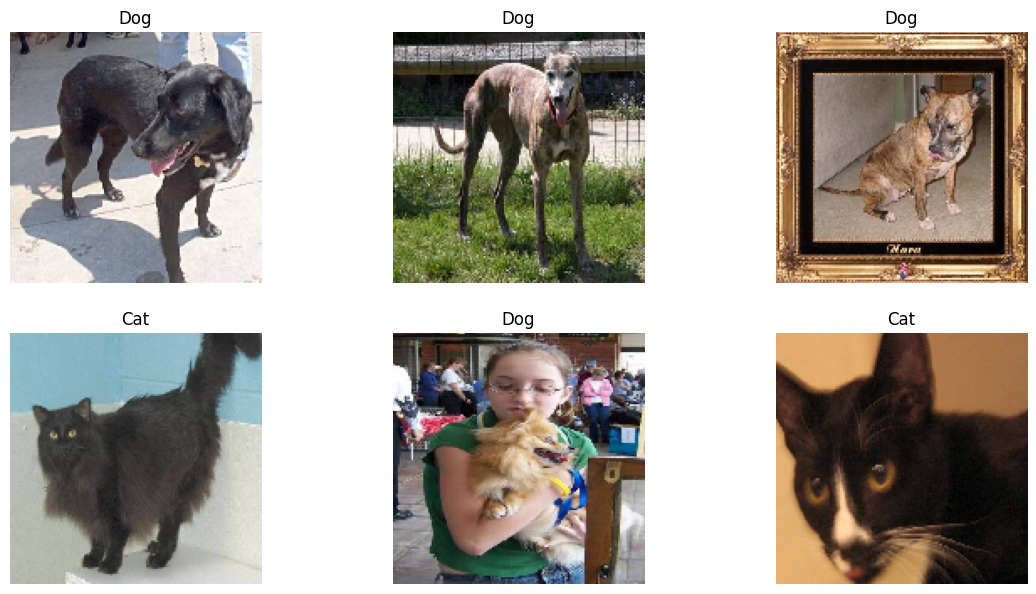

In [25]:
plot_data(train_generator,7)


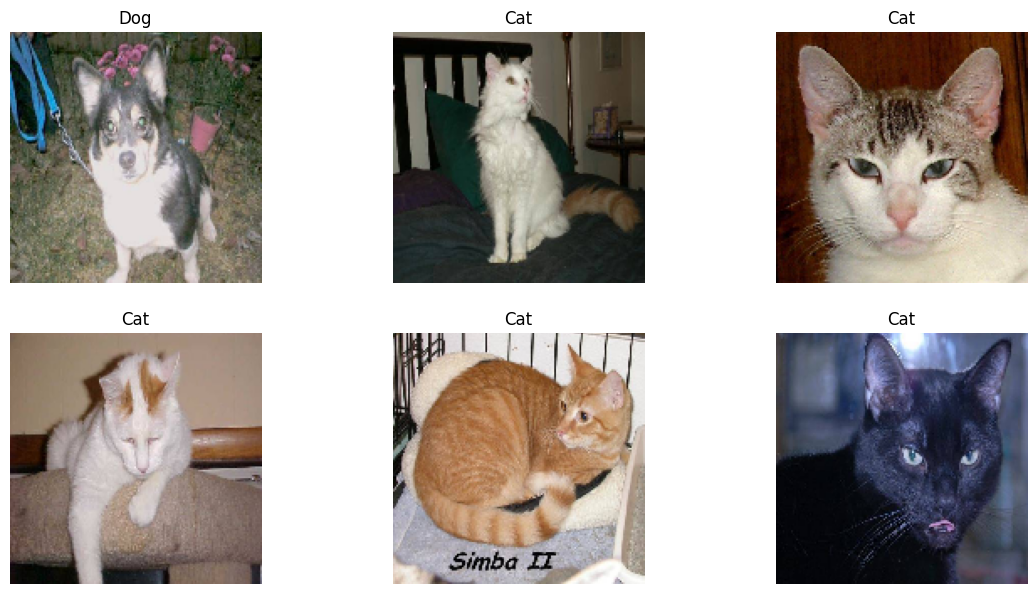

In [26]:
plot_data(validation_generator,7)


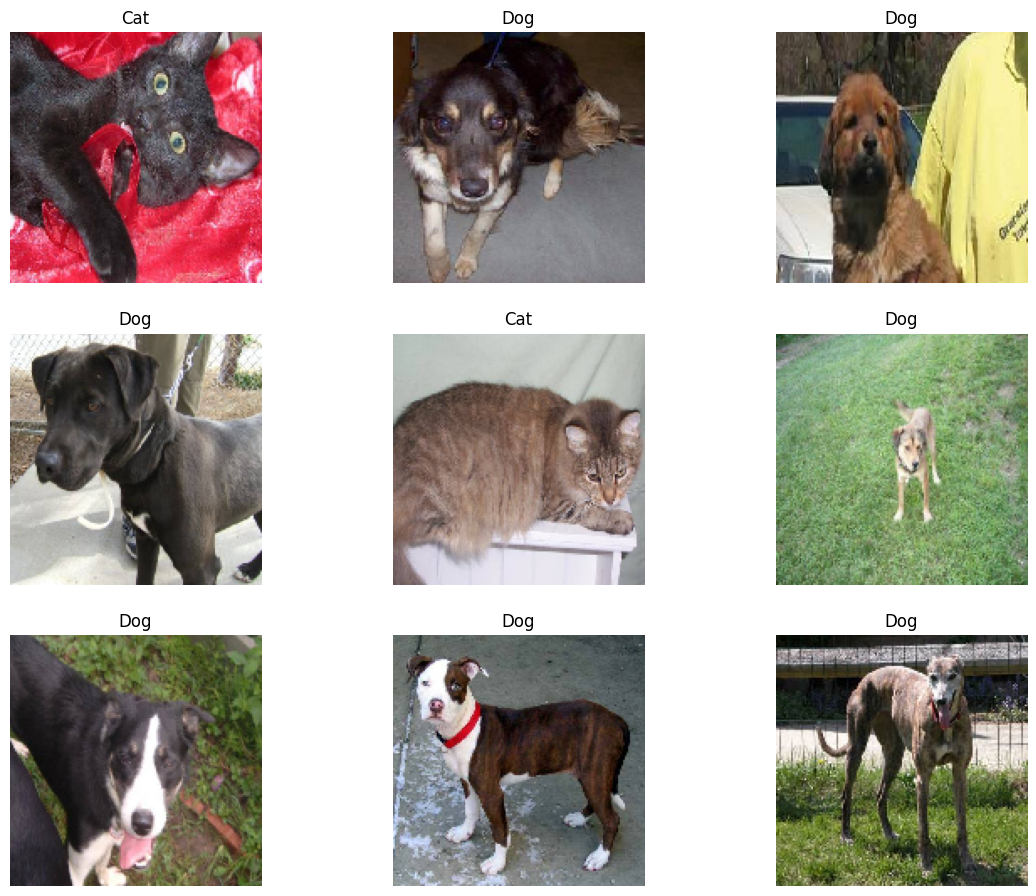

In [27]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [28]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:

r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6052 - loss: 0.6596 - val_accuracy: 0.5436 - val_loss: 0.6753
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6052 - loss: 0.6596 - val_accuracy: 0.5436 - val_loss: 0.6753
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6010 - loss: 0.6660 - val_accuracy: 0.5333 - val_loss: 0.6729
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6010 - loss: 0.6660 - val_accuracy: 0.5333 - val_loss: 0.6729
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5862 - loss: 0.6588 - val_accuracy: 0.5282 - val_loss: 0.6827
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5862 - loss: 0.6588 - val_accuracy: 0.5282 - val_loss: 0.6827
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6222 - loss: 0.6436 - val_accuracy: 0.5590 - val_loss: 0.7080
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6222 - loss: 0.6436 - val_accuracy: 0.5590 - v

In [32]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.6190 - loss: 0.6208
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step - accuracy: 0.6190 - loss: 0.6208


<a name="4-2"></a>

## Visualize the predicitons

In [33]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    # Use next(generator) instead of generator.next() for newer TensorFlow versions
    images, labels = next(generator)
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i-1] == labels[i-1]:  # Fixed index issue
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images + 1:  # Fixed off-by-one error
            break
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


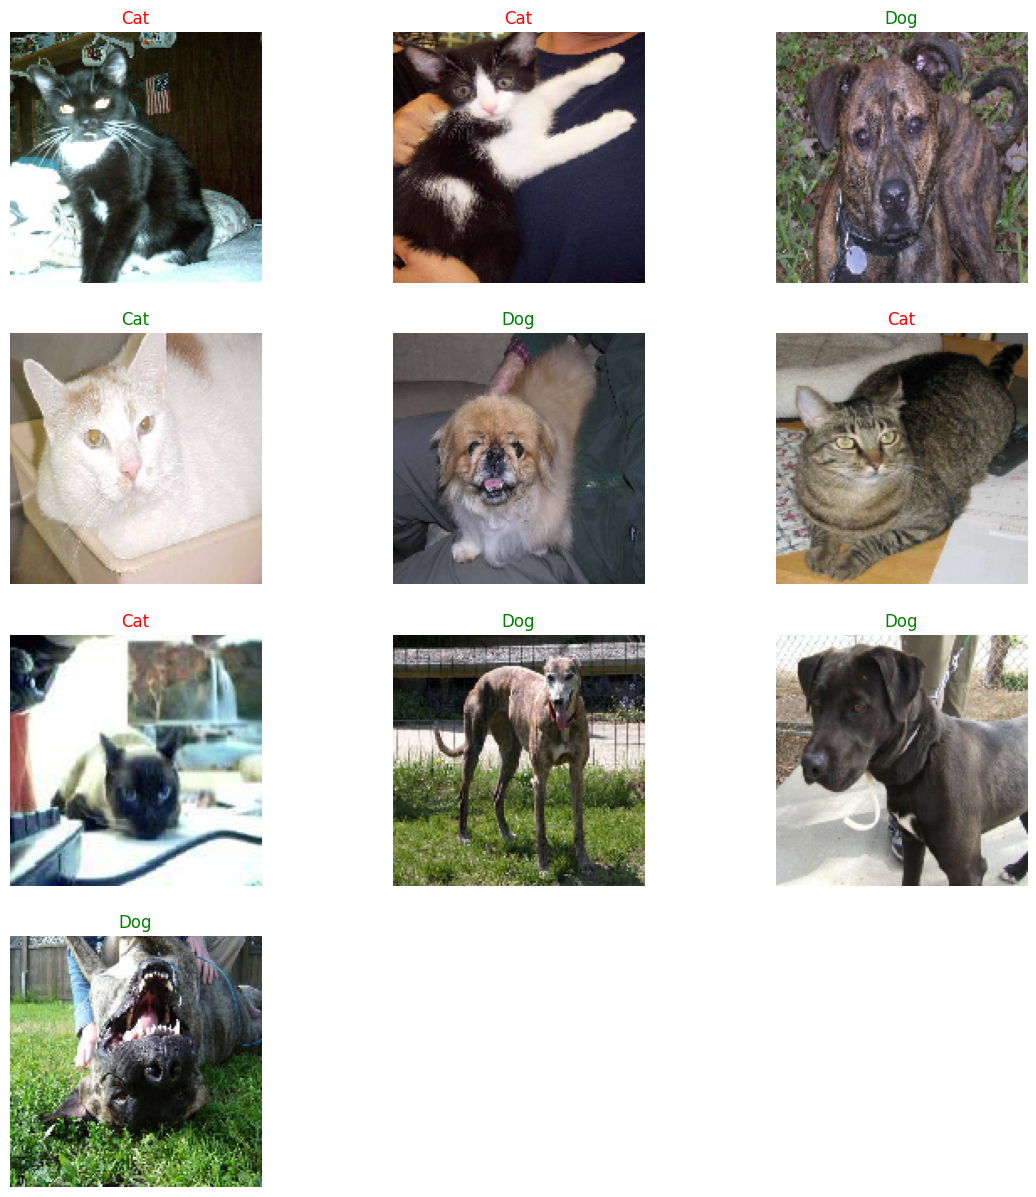

In [34]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


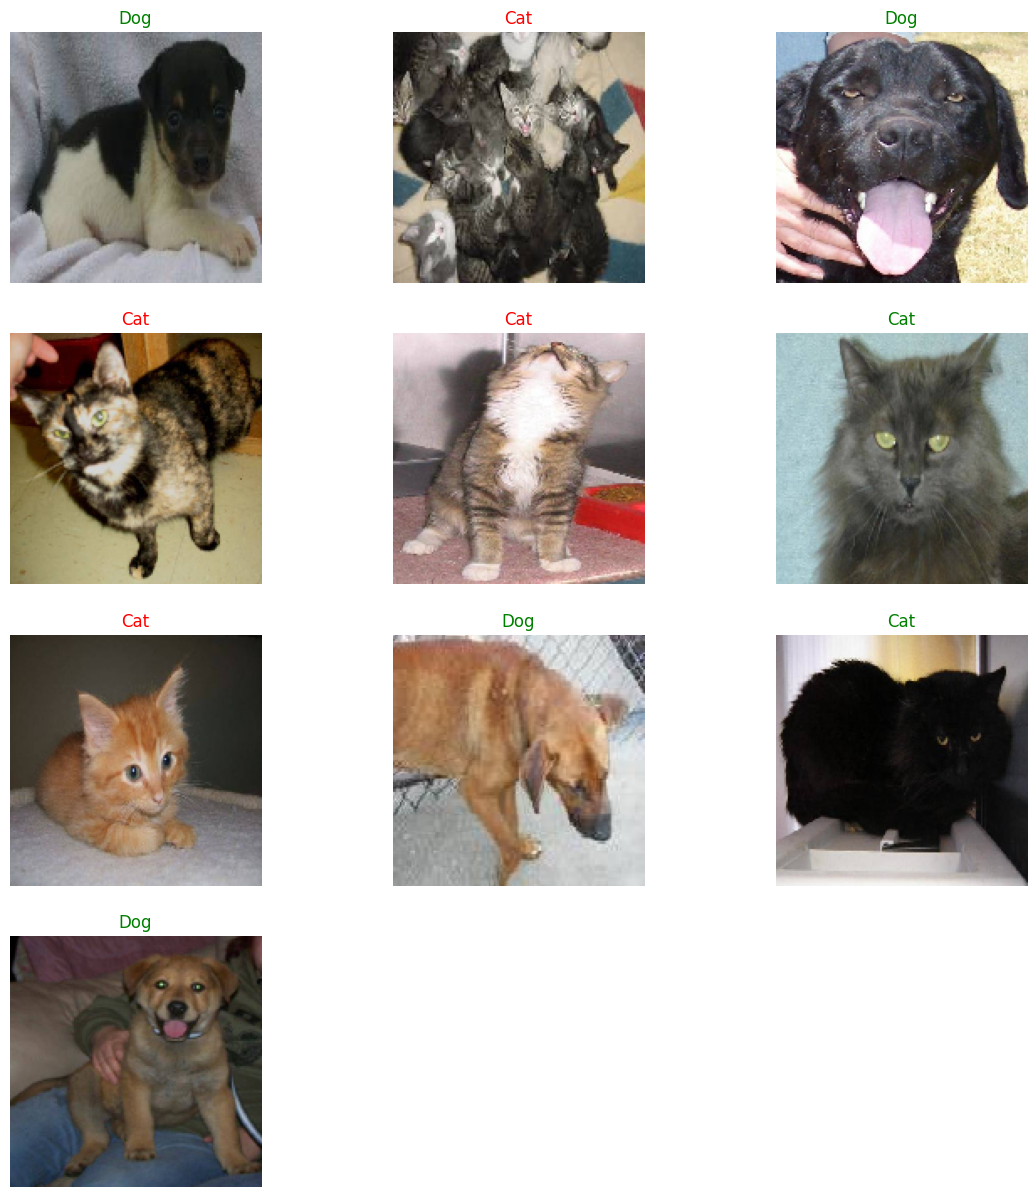

In [35]:
plot_prediction(validation_generator, 10)

In [36]:
# Create a  model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [37]:
# Use the model to make predictions on the test generator
# Use next(generator) instead of generator.next() for newer TensorFlow versions
images, _ = next(test_generator)
features, results = activation_model.predict(images)

c:\Users\saich\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


In [38]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image
    
    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [39]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated 
    '''
    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

Predicted Class = Dog, Probability = 0.65928113


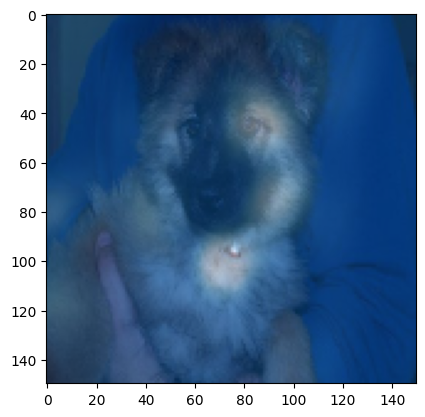

Predicted Class = Dog, Probability = 0.71545297


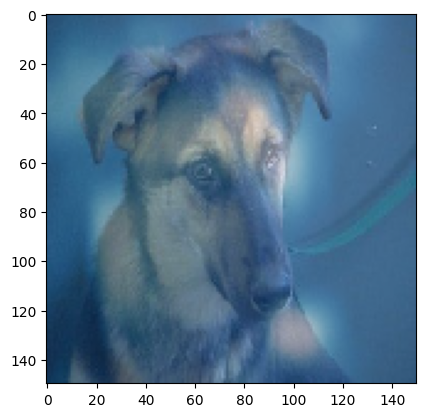

Predicted Class = Dog, Probability = 0.9735787


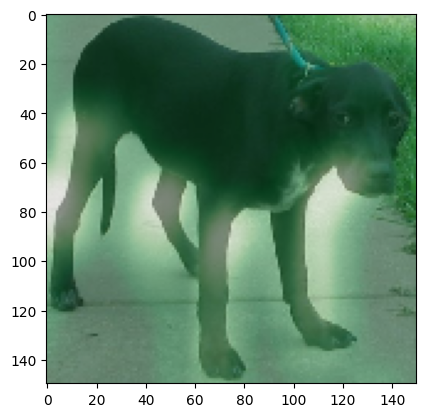

Predicted Class = Dog, Probability = 0.999998


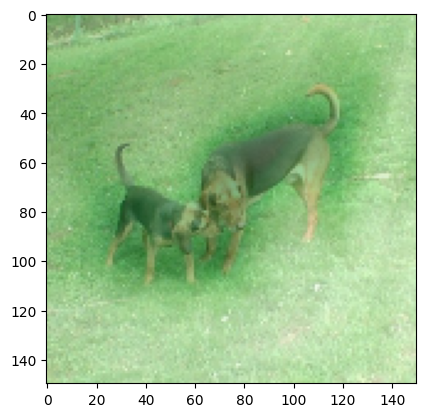

Predicted Class = Dog, Probability = 0.51994264


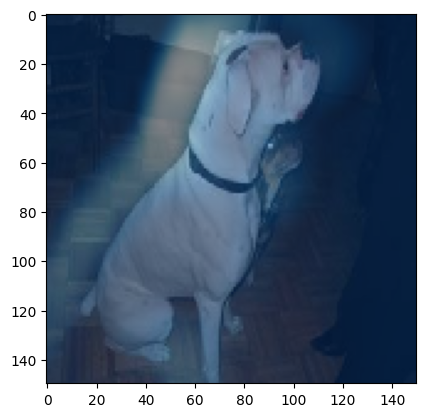

In [40]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.92931265


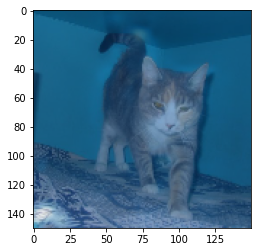

Predicted Class = Cat, Probability = 0.69228625


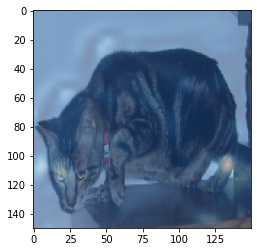

Predicted Class = Cat, Probability = 0.99844223


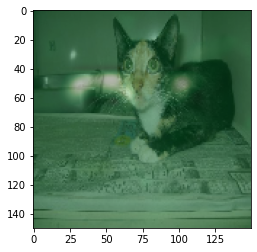

Predicted Class = Cat, Probability = 0.74661374


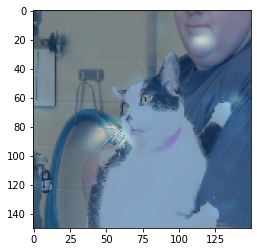

Predicted Class = Cat, Probability = 0.75617355


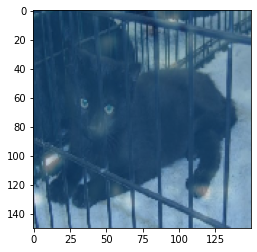

In [ ]:
show_maps(desired_class=0, num_maps=5)